# Project 6b - Linear system perspective

We have heretofore been approaching the discretization of spatial derivatives as a *convolution* operation, in which we slide a second derivative kernel over a function in order to get a function response.  An important fact is that convolution is a linear operation, which means that it's transitive and associative and all that, but stuff, but also that we can rewrite the convolution operation by a matrix.  To see this, recall that for some arbitrary location in the domain, we have as a right hand side
$$
\frac{\partial u_i}{\partial t} = \frac{k}{\Delta x^2} \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} \begin{bmatrix} u_{i-1} \\ u_i \\ u_{i+1}\end{bmatrix}.
$$
Of course, we also have that 
$$
\frac{\partial u_{i+1}}{\partial t} = \frac{k}{\Delta x^2} \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} \begin{bmatrix} u_{i} \\ u_{i+1} \\ u_{i+2}\end{bmatrix}.
$$
If we put these together, we could write the equation for both locations simultaneously as 
$$
\begin{bmatrix}\frac{\partial u_{i}}{\partial t} \\ \frac{\partial u_{i+1}}{\partial t}\end{bmatrix}  = \frac{k}{\Delta x^2} \begin{bmatrix} 1 & -2 & 1 & 0 \\ 0 & 1 & -2 & 1 \end{bmatrix} \begin{bmatrix} u_{i-1} \\ u_{i} \\ u_{i+1} \\ u_{i+2}\end{bmatrix}.
$$
If we expanded this to every location in the domain, we could write this rather simply as 
$$
\frac{\partial \mathbf{u}}{\partial t} = A \mathbf{u},
$$
where
$$
A = \frac{k}{\Delta x^2}\begin{bmatrix}     -2 &  1 & 0 & \cdots & 0 & 0 & 1 \\
                     1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
                     0 &  1 & 2 & \cdots & 0 & 0 & 0 \\
                     \vdots &  \vdots & \vdots & \ddots &\vdots  & \vdots & \vdots \\
                     0 & 0 & 0 & \cdots  & 1 & -2 & 1 \\
                     1 & 0 & 0 & \cdots  & 0 & 1 & -2
                      \end{bmatrix},
$$
and where we have assumed periodic boundary conditions.  To impose other boundary conditions, we can simply modify the rows commensurately with the formulae that we've seen previously.  For example, to handle the case where we have a Dirichlet boundary on the left hand side, and a Neumann boundary on the right, we can write
$$
\frac{\partial \mathbf{u}}{\partial t} = A \mathbf{u} + \mathbf{b},
$$
where
$$
A = \frac{k}{\Delta x^2} \begin{bmatrix}     0 &  0 & 0 & \cdots & 0 & 0 & 0 \\
                     1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
                     0 &  1 & 2 & \cdots & 0 & 0 & 0 \\
                     \vdots &  \vdots & \vdots & \ddots &\vdots  & \vdots & \vdots \\
                     0 & 0 & 0 & \cdots  & 1 & -2 & 1 \\
                     0 & 0 & 0 & \cdots  & 0 & 2 & -2
                      \end{bmatrix},
$$
and 
$$
\mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ \frac{2 C}{\Delta x} \end{bmatrix}.
$$
**Modify your diffusion problem to utilize this matrix formulation, then ensure that your solutions are equivalent to those you computed with the convolution approach.  (Bonus credibility if you can write this code to handle either Dirichlet or Neumann conditions on either boundary.)  (Bonus bonus credibility if you can make this work with a sparse matrix data type.)**












In [1]:
# numpy.linalg.solve(A, b) = Ax = b

In [2]:
import numpy as np
import ode_methods as om
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
import numpy.linalg as nl

In [154]:
class Diffusion:
    
    def __init__(self,dx,k=0.01, A=None, b=None):
        
        self.k = k    # diffusion coefficient
        self.dx = dx**2
        self.A = A
        self.b = b

    def rhs(self,t,u):
        dudt = np.dot(self.A, u) + self.b
        return np.array(dudt).flatten()


In [152]:
class Diffusion:
    
    def __init__(self,dx,k=0.01, A=None, b=None):
        
        self.k = k    # diffusion coefficient
        self.dx = dx**2
        self.A = A
        self.b = b

    def rhs(self,t,u):
        dudt = np.dot(self.A, u) + self.b
        return np.array(dudt).flatten()

def make_matrix(size=5, boundary="D",k=0.01, dx=0.1):
    A = np.zeros((size, size))
    b = np.zeros(size)

    if boundary == "P":
        for i in range(size):
            A[i,i] = -2
            if i > 0:
                    A[i,i-1] = 1
            if i < size-1:
                    A[i,i+1] = 1

    elif boundary == "D":
        for i in range(size):
            A[i,i] = -2
            if i > 0:
                    A[i,i-1] = 1
            if i < size-1:
                    A[i,i+1] = 1
        b[-1] = 2*k /dx

    elif boundary == "N":
        for i in range(size):
            A[i,i] = -2
            if i > 0:
                    A[i,i-1] = 1
            if i < size-1:
                    A[i,i+1] = 1
        b[0] = 2*k /dx
        b[-1] = 2*k /dx

    elif boundary == "T":
        for i in range(size):
            A[i,i] = -2
            if i > 0:
                    A[i,i-1] = 1
            if i < size-1:
                    A[i,i+1] = 1
        b[-1] = 2*k /dx
        
        A[0,0] = 0
        A[0,1] = 0
        A[-1,-1] = -2
        A[-1,-2] = 2

    return A, b

A, b = make_matrix(size=100, boundary="T", k=0.1, dx=0.1)
method = om.Midpoint()
diffusion = Diffusion(dx=0.1,k=0.01, A=A, b=b)
u_0 = np.zeros(100)
u_0[0] = 1
integrator = om.Integrator(diffusion,method)
t,u = integrator.integrate([0,30],0.005,u_0)

cmap = plt.cm.viridis

for tt,uu in zip(t[::100],u[::100]):
    plt.plot(u_0,uu,color=cmap(tt/t[-1]))
plt.show()

In [176]:
import numpy as np
import matplotlib.pyplot as plt

class Diffusion:
    
    def __init__(self, dx, k=0.01, A=None, b=None):
        self.k = k    # diffusion coefficient
        self.dx = dx**2
        self.A = A
        self.b = b

    def rhs(self, t, u):
        dudt = np.dot(self.A, u) + self.b
        return np.array(dudt).flatten()

def make_matrix(size=5, boundary="D", k=0.01, dx=0.1):
    A = np.zeros((size, size))
    b = np.zeros(size)

    if boundary == "P":
        for i in range(size):
            A[i, i] = -2
            if i > 0:
                A[i, i - 1] = 1
            if i < size - 1:
                A[i, i + 1] = 1

    elif boundary == "D":
        for i in range(size):
            A[i, i] = -2
            if i > 0:
                A[i, i - 1] = 1
            if i < size - 1:
                A[i, i + 1] = 1
        b[-1] = 2 * k / dx

    elif boundary == "N":
        for i in range(size):
            A[i, i] = -2
            if i > 0:
                A[i, i - 1] = 1
            if i < size - 1:
                A[i, i + 1] = 1
        b[0] = 2 * k / dx
        b[-1] = 2 * k / dx

    elif boundary == "T":
        for i in range(size):
            A[i, i] = -2
            if i > 0:
                A[i, i - 1] = 1
            if i < size - 1:
                A[i, i + 1] = 1
        b[-1] = 2 * k / dx

        A[0, 0] = 0
        A[0, 1] = 0
        A[-1, -1] = -2
        A[-1, -2] = 2

    return A, b


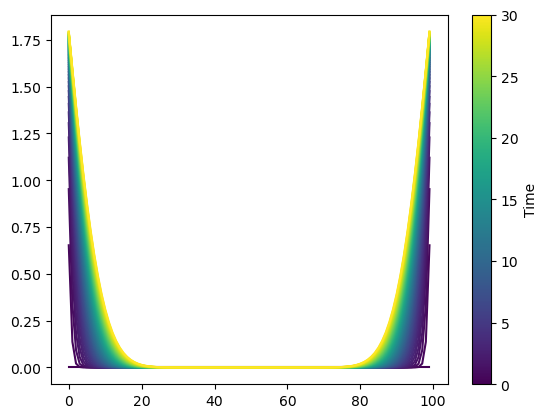

In [178]:
A, b = make_matrix(size=100, boundary="N", k=0.1, dx=0.1)
diffusion = Diffusion(dx=0.1, k=0.01, A=A, b=b)
u_0 = np.zeros(100)
integrator = om.Integrator(diffusion, method)
t, u = integrator.integrate([0, 30], 0.005, u_0)


fig, ax = plt.subplots()

cmap = plt.cm.viridis

for tt, uu in zip(t[::100], u[::100]):
    ax.plot(uu, color=cmap(tt/t[-1]))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=t[-1]))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Time')
plt.show()